In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import random
import time
warnings.filterwarnings("ignore")

# Defining the problem 

### We all know cardiovascular disease is caused by myriad factors. 
### Our problem would be to understand various, potentially, contributing factor for cardiovascular disease and understand which ones are the most detrimental
### Additionally, we also seek to understand if these features provided are enough to predict the existence of cardiovascular disease

# Data Import

In [3]:
input_dir = 'cardio_train.csv'

df = pd.read_csv(input_dir, sep=';')
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#### Age | Objective Feature | age | int (days)
#### Height | Objective Feature | height | int (cm) |
#### Weight | Objective Feature | weight | float (kg) |
#### Gender | Objective Feature | gender | categorical code |
#### Systolic blood pressure | Examination Feature | ap_hi | int |
#### Diastolic blood pressure | Examination Feature | ap_lo | int |
#### Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
#### Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
#### Smoking | Subjective Feature | smoke | binary |
#### Alcohol intake | Subjective Feature | alco | binary |
#### Physical activity | Subjective Feature | active | binary |
#### Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

# Data Preparation and Data Cleaning

In [4]:
# Creating age(years) columns in the df
df['age_years'] = df['age'] // 365

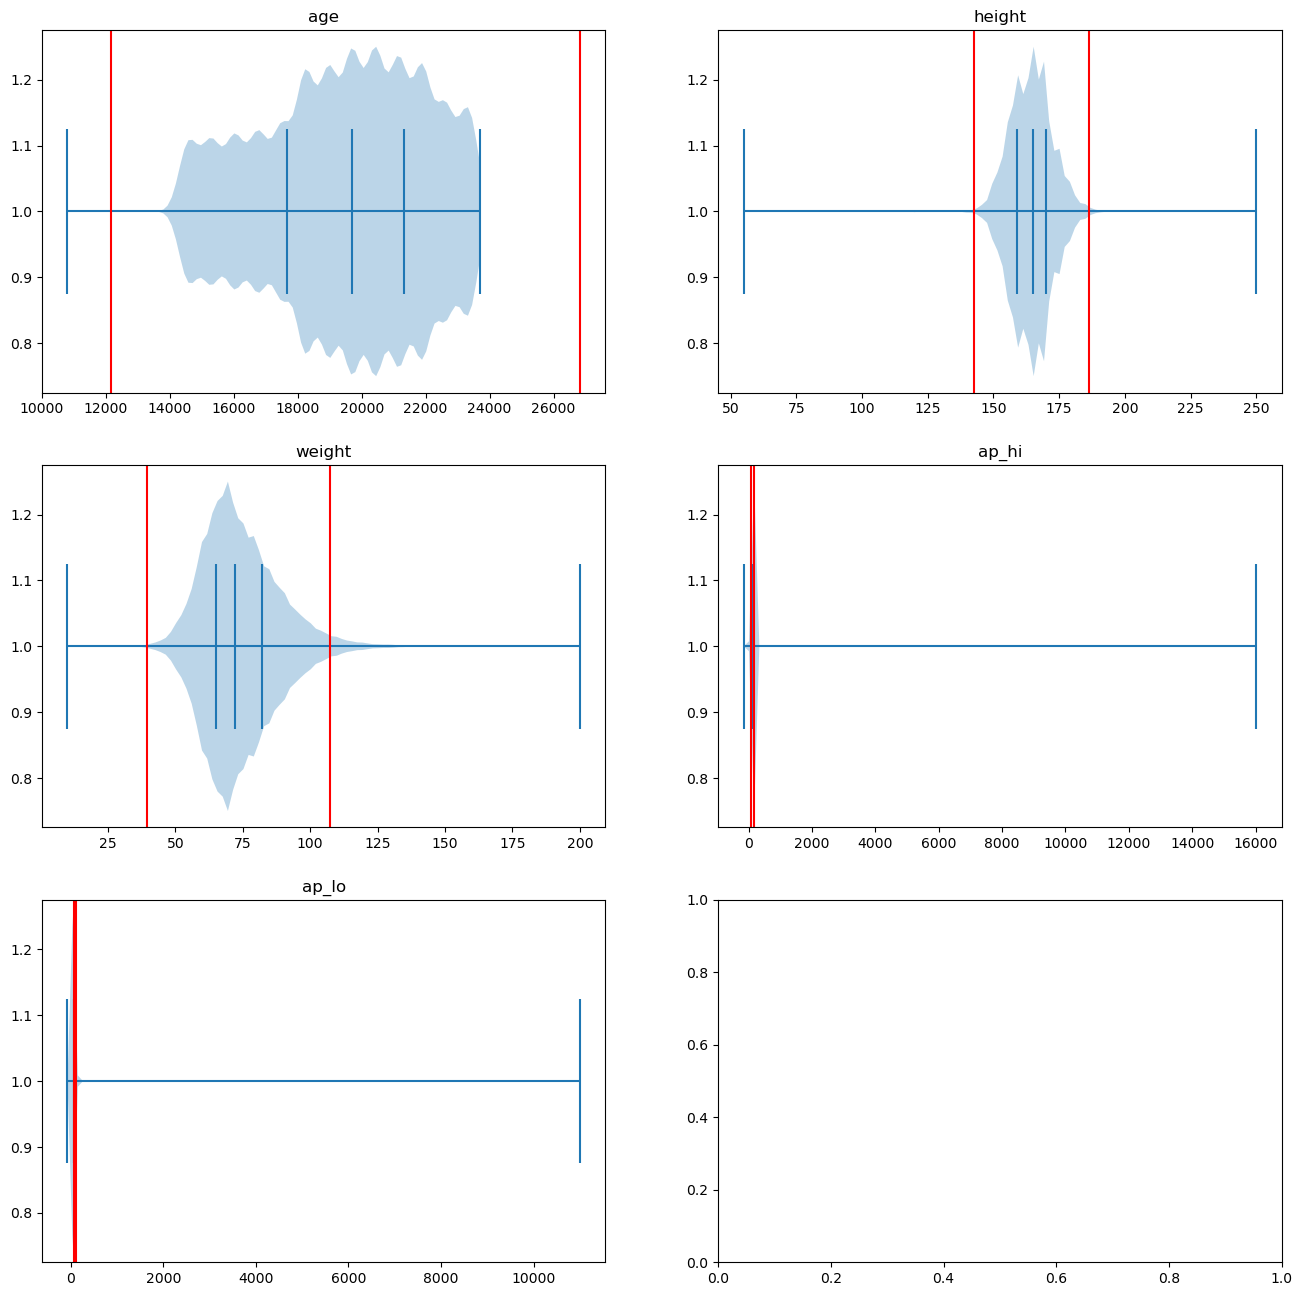

In [5]:
# Checking for any outliers for continuous variable 
# The red vertical lines show the outlier region calculated
from scipy.stats import iqr

fig, axs = plt.subplots(3, 2, figsize=(16, 16))
continuous_var = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

for i, var in enumerate(continuous_var):
    axs[i//2, i%2].violinplot(df[var], vert=False, showmeans=False, showextrema = True, showmedians=False, quantiles = [0.25, 0.5, 0.75])
    axs[i//2, i%2].set_title(var)
    IQR = iqr(df[var])
    q1 = np.quantile(df[var], 0.25)
    q3 = np.quantile(df[var], 0.75)
    low_outlier_limit = q1 - 1.5*IQR
    high_outlier_limit = q3 + 1.5*IQR
    axs[i//2, i%2].axvline(low_outlier_limit, c = 'red')
    axs[i//2, i%2].axvline(high_outlier_limit, c = 'red')
plt.show()

In [6]:
# Let us make a different dataset without all these outliers 
df_no_outliers = df.copy()
for var in continuous_var:
    IQR = iqr(df_no_outliers[var])
    q1 = np.quantile(df_no_outliers[var], 0.25)
    q3 = np.quantile(df_no_outliers[var], 0.75)
    low_outlier_limit = q1 - 1.5*IQR
    high_outlier_limit = q3 + 1.5*IQR
    initial_len = len(df_no_outliers)
    df_no_outliers = df_no_outliers[(df_no_outliers[var] < high_outlier_limit) & (df_no_outliers[var] > low_outlier_limit)]
    end_len = len(df_no_outliers)
    print(f"Total removed rows for features \'{var}\': {initial_len-end_len} ({(initial_len-end_len)/initial_len*100:.2f}%)")

Total removed rows for features 'age': 4 (0.01%)
Total removed rows for features 'height': 519 (0.74%)
Total removed rows for features 'weight': 1758 (2.53%)
Total removed rows for features 'ap_hi': 2916 (4.31%)
Total removed rows for features 'ap_lo': 3032 (4.68%)


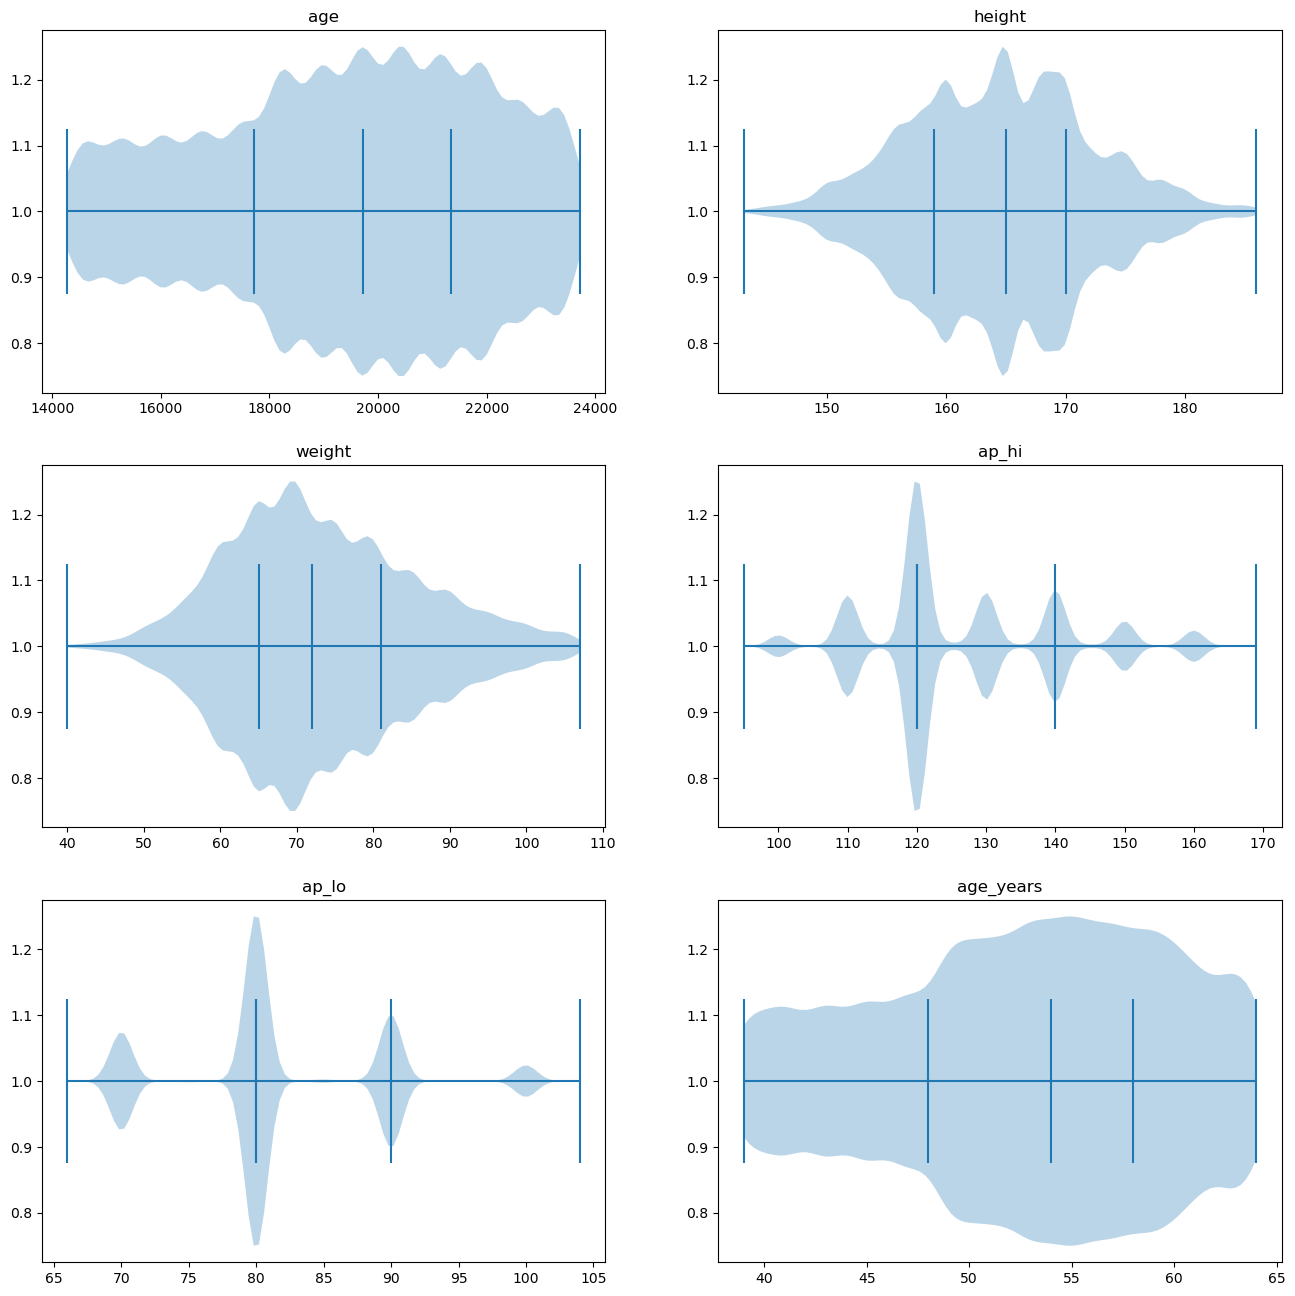

In [7]:
# Plot again after removing outliers

fig, axs = plt.subplots(3, 2, figsize=(16, 16))
continuous_var = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'age_years']

for i, var in enumerate(continuous_var):
    axs[i//2, i%2].violinplot(df_no_outliers[var], vert=False, showmeans=False, showextrema = True, showmedians=False, quantiles = [0.25, 0.5, 0.75])
    axs[i//2, i%2].set_title(var)
plt.show()

In [8]:
df_no_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,19699,1,172,70.0,130,90,1,1,0,0,1,1,53
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,57
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,52
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61


In [9]:
def one_hot_encode_dataframe(df, columns):
    df_encoded = df.copy()
    
    # Perform one-hot encoding using pandas get_dummies() function
    df_encoded = pd.get_dummies(df_encoded, columns=columns, dtype='int')
    
    return df_encoded

df_no_outliers_one_hot_encoded = one_hot_encode_dataframe(df_no_outliers, ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'])

# EDA and Visualization

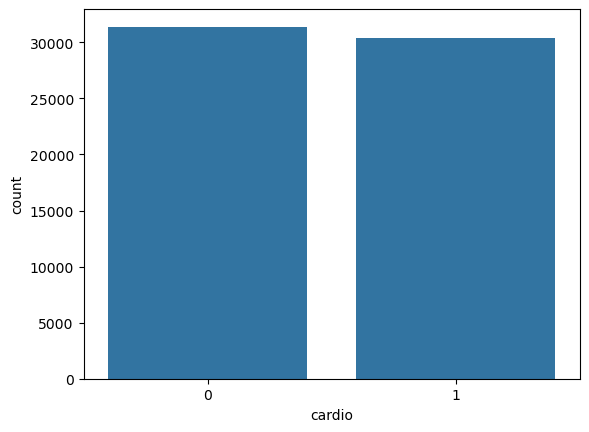

In [10]:
# Overall very balanced dataset

sns.countplot(x='cardio', data=df_no_outliers)
plt.show()

In [11]:
continuous_var

['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'age_years']

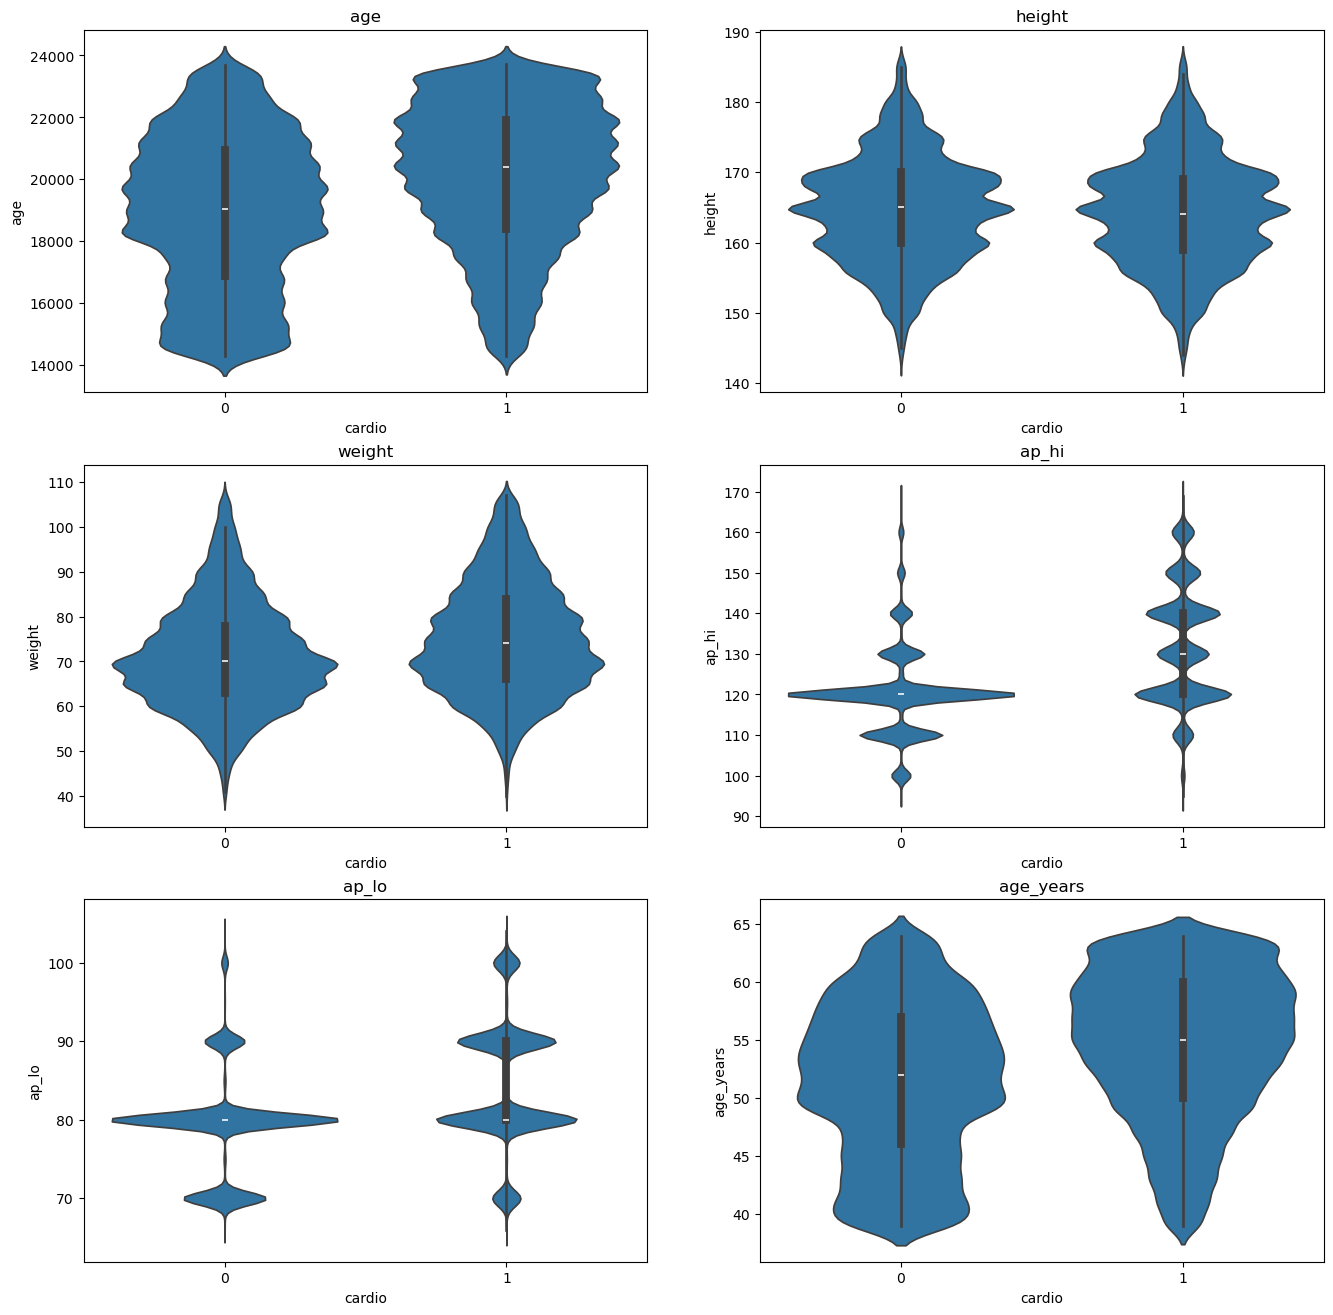

In [12]:
# Check for any correlation through visualization since target variable is categorical
# Height doesn't seem to be a defining feature when predicting cardio
# However, age and weight does seem to play a part in determining presence of cardiovascular disease
# ap_hi also does seem to play a role in determining cardio - "Elevated SBP remains the foremost modifiable risk factor for attributable cardiovascular mortality globally." from https://www.ahajournals.org/doi/10.1161/HYPERTENSIONAHA.123.20788 proves our visualization correct
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
for i, var in enumerate(continuous_var):
    sns.violinplot(df_no_outliers, x = 'cardio', y = var, ax = axs[i//2, i%2])
    axs[i//2, i%2].set_title(var)
plt.show()

The pearson correlation for the two variables are 0.7040184864824605


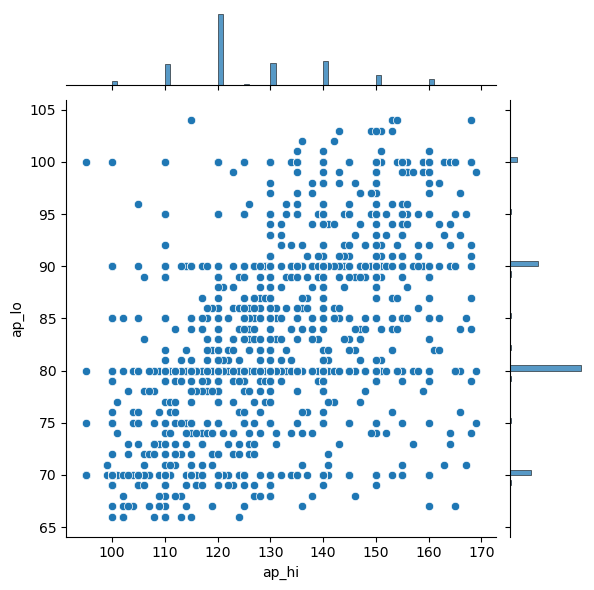

In [13]:
# Check for any relationship between ap_hi and ap_lo
# Seems like there a somewhat linear relationship, albeit not that strong
# Upon closer analysis of the columns, it seems that these are mostly categorical data rather than continuous data
# However, to make it into a categorical variable, it would be too much different classes so we'll keep it as it is for now

from scipy import stats

corr = stats.pearsonr(df_no_outliers['ap_hi'], df_no_outliers['ap_lo'])
print(f"The pearson correlation for the two variables are {corr.statistic}")

sns.jointplot(data=df_no_outliers, x="ap_hi", y="ap_lo")
plt.show()

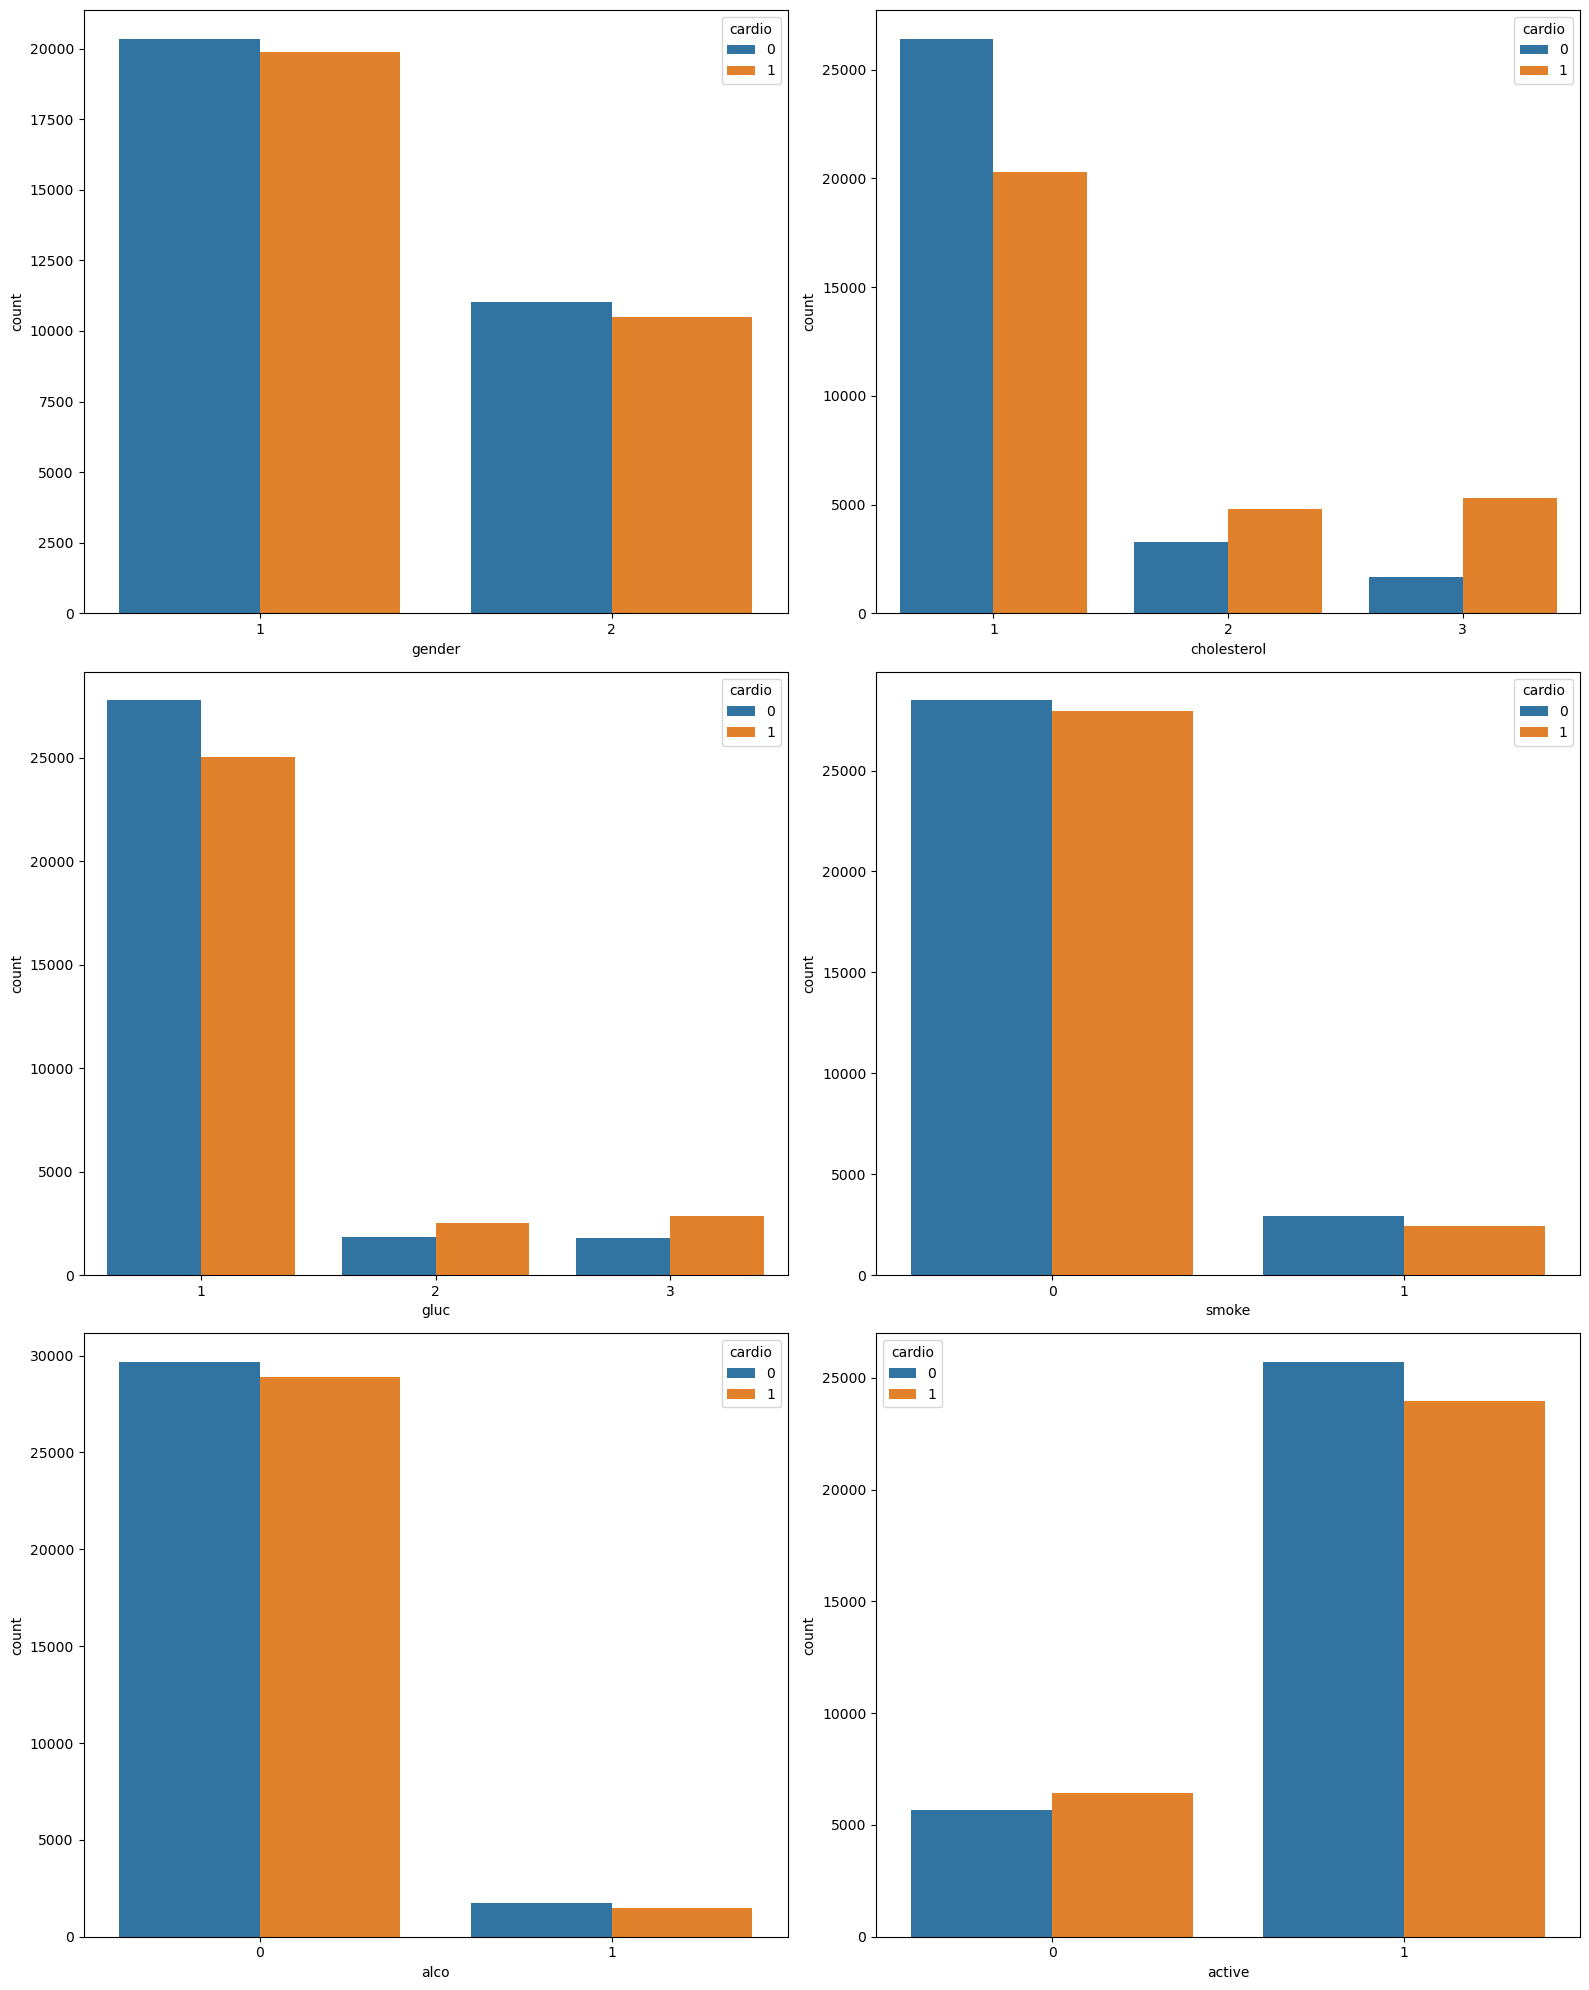

In [14]:
categorical_variables = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

fig, axs = plt.subplots(3, 2, figsize=(16, 20))
for i, var in enumerate(categorical_variables):
    sns.countplot(data = df_no_outliers, x=var, hue='cardio', ax = axs[i//2, i%2])
    # axs[i//2, i%2].set_title(var)
fig.tight_layout()
plt.show()

### Amongst the categorical variables, we can see that **cholesterol**, **gluc** and **active** variables affect the existence of cardio. 
### These variables show a difference in the proportion of cardio distribution in each of its class. 

# Machine Learning

### 2 class classification task - balanced dataset
### Decision Tree, Random Forest, Logistic Regression, XGBClassifier and KNN
### Hyperparameter Tuning through GridSearch and possibly optuna (see how)
### Observe feature importances

In [15]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [51]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_jobs=-1, n_estimators=300)
xgbc = XGBClassifier(objective='binary:logistic', verbosity = 0)
knn = KNeighborsClassifier(n_neighbors=50, n_jobs=-1)
models = [lr, dt, rf, xgbc, knn]
model_name = ['logistic regression', 'decision tree', 'random forest', 'xgbclassifier', 'knn']

In [52]:
col = list(df_no_outliers.columns)
col.remove('id')
col.remove('cardio')

#col.remove('height')
#col.remove('gender')
#col.remove('age_years')

features = col
target = 'cardio'

In [53]:
# Scaling the data for Logistic Regression and KNN model 
scaled_df = df_no_outliers.copy()
scaled_df.drop('cardio', axis=1, inplace=True)
scaler = StandardScaler()
transformed = scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(transformed, columns=scaled_df.columns)
scaled_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years
0,-1.730589,-0.446676,1.366213,0.475450,-0.911169,-1.181826,-0.218227,-0.527927,-0.387928,-0.307586,-0.234241,0.493257,-0.430377
1,-1.730555,0.300102,-0.731951,-1.118959,0.966854,1.009150,1.103429,2.439097,-0.387928,-0.307586,-0.234241,0.493257,0.311565
2,-1.730520,-0.257845,-0.731951,0.076848,-0.747862,0.278824,-1.539883,2.439097,-0.387928,-0.307586,-0.234241,-2.027340,-0.281989
3,-1.730486,-0.760038,1.366213,0.608317,0.721895,1.739475,2.425086,-0.527927,-0.387928,-0.307586,-0.234241,0.493257,-0.727154
4,-1.730312,0.986242,-0.731951,-1.783296,-0.502903,-0.451501,-0.218227,0.955585,1.374553,-0.307586,-0.234241,-2.027340,1.053507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,1.733154,0.084818,-0.731951,1.006920,-0.257943,0.278824,1.103429,-0.527927,-0.387928,-0.307586,-0.234241,0.493257,0.014788
61767,1.733188,0.644393,-0.731951,0.076848,0.558588,1.739475,-0.218227,-0.527927,-0.387928,-0.307586,-0.234241,0.493257,0.608342
61768,1.733223,-0.101978,1.366213,0.475450,0.231976,-0.451501,-0.218227,-0.527927,-0.387928,3.251118,-0.234241,0.493257,-0.133600
61769,1.733396,1.196642,-0.731951,-0.188887,-0.094637,0.643987,-0.218227,-0.527927,1.374553,-0.307586,-0.234241,-2.027340,1.201896


In [54]:
def cross_vaildation(model, scoring = 'accuracy', scaled=False):
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True)

    if scaled:
        X, y = scaled_df[features], df_no_outliers[target]
    else:
         X, y = df_no_outliers[features], df_no_outliers[target]

    outer_scores = []
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

        validation_score = cross_val_score(model, X_train_outer, y_train_outer, cv = inner_cv)
        model.fit(X_train_outer, y_train_outer)
        testing_score = model.score(X_test_outer, y_test_outer)
        outer_scores.append(testing_score)
        print(f"====Iteration {i+1} | Validation score: {np.mean(validation_score):.2f} | Test score: {testing_score:.2f}====")

    average_score = sum(outer_scores) / len(outer_scores)
    print("Average score:", average_score)
    return average_score

In [55]:
%%time

for name, m in zip(model_name, models):
    print(f"Testing for model {name}")
    if name == 'logistic regression' or name == 'knn':
        cross_vaildation(m, scaled=True)
    else:
        cross_vaildation(m)

Testing for model logistic regression
====Iteration 1 | Validation score: 0.72 | Test score: 0.71====
====Iteration 2 | Validation score: 0.72 | Test score: 0.72====
====Iteration 3 | Validation score: 0.72 | Test score: 0.72====
====Iteration 4 | Validation score: 0.72 | Test score: 0.73====
====Iteration 5 | Validation score: 0.72 | Test score: 0.72====
====Iteration 6 | Validation score: 0.72 | Test score: 0.73====
====Iteration 7 | Validation score: 0.72 | Test score: 0.72====
====Iteration 8 | Validation score: 0.72 | Test score: 0.72====
====Iteration 9 | Validation score: 0.72 | Test score: 0.73====
====Iteration 10 | Validation score: 0.72 | Test score: 0.72====
Average score: 0.7213581639047473
Testing for model decision tree
====Iteration 1 | Validation score: 0.63 | Test score: 0.63====
====Iteration 2 | Validation score: 0.63 | Test score: 0.63====
====Iteration 3 | Validation score: 0.63 | Test score: 0.63====
====Iteration 4 | Validation score: 0.63 | Test score: 0.63====

### Seems like Logistic Regression and XGBClassifier performs the best

# Hyperparameter Tuning

In [58]:

# Perform a 10 fold stratified nested cross validation for hyperparameter tuning

def tuning(model, param_grid, scoring = 'accuracy', scaled=True):

    outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    if scaled:
        X, y = scaled_df[features], df_no_outliers[target]
    else:
         X, y = df_no_outliers[features], df_no_outliers[target]

    outer_scores = []
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
        y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

        grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                        cv=inner_cv, 
                                        n_iter=20, 
                                        scoring = scoring, 
                                        verbose = 0, 
                                        n_jobs = -1)
        grid_search.fit(X_train_outer, y_train_outer)

        # Obtain the best model throughout the gridsearch 
        best_model = grid_search.best_estimator_

        # Evaluate best model on outer test set
        outer_score = best_model.score(X_test_outer, y_test_outer)
        print(f"====Iteration {i+1} | Score: {outer_score:.2f}====")
        outer_scores.append(outer_score)

    average_score = sum(outer_scores) / len(outer_scores)
    print("Average score:", average_score)
    print("Best estimator: ", grid_search.best_params_)
    return average_score, best_model

In [59]:
%%time

param_distributions = {
  'n_neighbors': stats.randint(50, 200),
  'weights': ['uniform', 'distance'], 
}
knn_score, knn_best = tuning(knn, param_distributions)

====Iteration 1 | Score: 0.72====
====Iteration 2 | Score: 0.72====
====Iteration 3 | Score: 0.72====
====Iteration 4 | Score: 0.72====
====Iteration 5 | Score: 0.72====
====Iteration 6 | Score: 0.72====
====Iteration 7 | Score: 0.72====
====Iteration 8 | Score: 0.73====
====Iteration 9 | Score: 0.72====
====Iteration 10 | Score: 0.72====
Average score: 0.7224263633620749
Best estimator:  {'n_neighbors': 126, 'weights': 'uniform'}
CPU times: user 58 s, sys: 1.13 s, total: 59.1 s
Wall time: 16min 24s


In [63]:
%%time
from scipy.stats import uniform, loguniform

param_distributions = {
  'C': loguniform(1e-4, 1e-1),  
  'tol': loguniform(1e-6, 1e-4), 
  'penalty': ['l1', 'l2'],    
  'solver': ['liblinear', 'lbfgs', 'saga']  
}
LR_score, LR_best = tuning(lr, param_distributions)

====Iteration 1 | Score: 0.72====
====Iteration 2 | Score: 0.72====
====Iteration 3 | Score: 0.72====
====Iteration 4 | Score: 0.72====
====Iteration 5 | Score: 0.73====
====Iteration 6 | Score: 0.73====
====Iteration 7 | Score: 0.72====
====Iteration 8 | Score: 0.72====
====Iteration 9 | Score: 0.72====
====Iteration 10 | Score: 0.71====
Average score: 0.7215035905553624
Best estimator:  {'C': 0.056054892800502854, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 1.4690211878466786e-05}
CPU times: user 9.56 s, sys: 7.36 s, total: 16.9 s
Wall time: 1min 15s


In [61]:
%%time
param_distributions = {
  'n_estimators': stats.randint(100, 1000),  
  'learning_rate': stats.uniform(0.01, 0.3),  
  'max_depth': range(1, 6),
  'min_child_weight': range(3, 9),  
  'colsample_bytree': stats.uniform(0.3, 0.8), 
  'subsample': stats.uniform(0.5, 1), 
}
XGB_score, XGB_best = tuning(xgbc, param_distributions, scaled=False)

====Iteration 1 | Score: 0.73====
====Iteration 2 | Score: 0.73====
====Iteration 3 | Score: 0.72====
====Iteration 4 | Score: 0.72====
====Iteration 5 | Score: 0.73====
====Iteration 6 | Score: 0.73====
====Iteration 7 | Score: 0.73====
====Iteration 8 | Score: 0.73====
====Iteration 9 | Score: 0.73====
====Iteration 10 | Score: 0.72====
Average score: 0.7287075541515577
Best estimator:  {'colsample_bytree': 0.6689972635295354, 'learning_rate': 0.01852605597377465, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 921, 'subsample': 0.8659662441255065}
CPU times: user 10.6 s, sys: 3.87 s, total: 14.5 s
Wall time: 1min 17s


# Data Driven Insight

Text(0.5, 1.0, 'Logistic Regression Feature Importance')

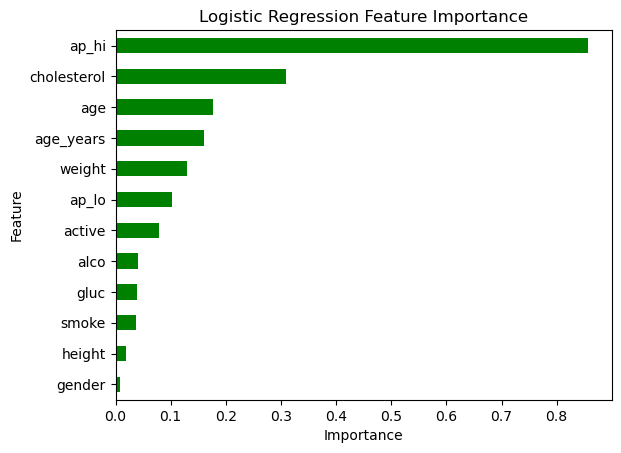

In [47]:
global_importances = pd.Series(np.abs(LR_best.coef_[0]), index=df_no_outliers[features].columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Logistic Regression Feature Importance")

Text(0.5, 1.0, 'XGBC Feature Importance')

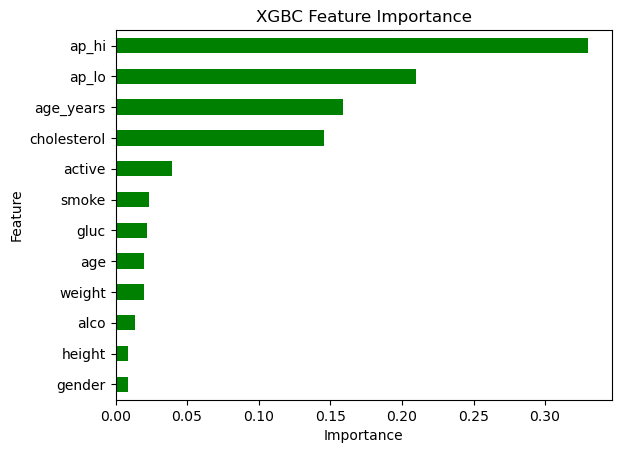

In [46]:
global_importances = pd.Series(XGB_best.feature_importances_, index=df_no_outliers[features].columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBC Feature Importance")

F1 score is: 0.699
Accuracy is: 72.303


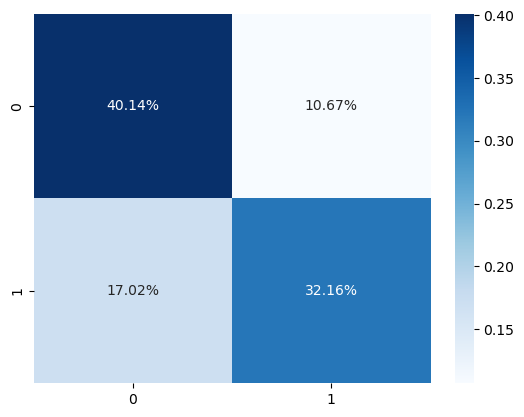

In [51]:
# Correlation Matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# LR = LogisticRegression()
LR = LogisticRegression(C = 0.00775, penalty='l1', solver='liblinear')
X, y = scaled_df[features], df_no_outliers[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
LR.fit(X_train,y_train)
pred = LR.predict(X_test)
cf_matrix = confusion_matrix(y_test, pred)
print(f"F1 score is: {f1_score(y_test, pred):.3f}")
print(f"Accuracy is: {accuracy_score(y_test, pred)*100:.3f}")
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

F1 score is: 0.716
Accuracy is: 73.191


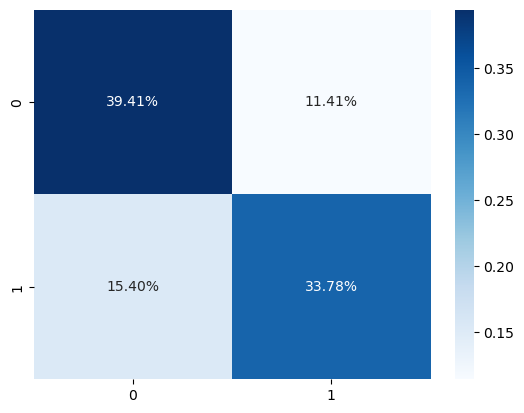

In [49]:
XGB = XGBClassifier(colsample_bytree = 0.5434583506278967, 
                    learning_rate = 0.17117,
                    max_depth = 3,
                    min_child_weight = 5,
                    n_estimators = 121,
                    subsample = 0.8609)
# XGB = XGBClassifier()
X, y = df_no_outliers[features], df_no_outliers[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
XGB.fit(X_train,y_train)
pred = XGB.predict(X_test)
cf_matrix = confusion_matrix(y_test, pred)
print(f"F1 score is: {f1_score(y_test, pred):.3f}")
print(f"Accuracy is: {accuracy_score(y_test, pred)*100:.3f}")
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

### There seems to be more of false negative than false positives, which could be pretty dangerous in a healthcare scenario. 
### With a high false positive, it would just be a large volume of inefficiencies, however with large volumes of false negatives, some patients' health may be in danger with missed opportunities for treatment. 